# Text detection

### Libraries

In [4]:
from pdf2image import convert_from_path

import boto3
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

### Functions

In [5]:
BOUNDING_BOX_KEYS = ['Width', 'Height', 'Left', 'Top']

In [6]:
def select_random_sample_from_list(l):
    n = len(l)
    index = np.random.randint(n)
    return l[index]

In [8]:
def draw_bounding_box(img, bounding_box, text=''):
    width = img.shape[1]
    height = img.shape[0]
    w, h = int(bounding_box[0]*width), int(bounding_box[1]*height)
    x, y = int(bounding_box[2]*width), int(bounding_box[3]*height)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 3)
    cv2.putText(img, text, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    return img

In [9]:
def convert_img_to_bytes(file):
    with open(file, 'rb') as f:
        source_bytes = f.read()
    return source_bytes

### AWS connection

In [10]:
bucket = 'text0detection'
bucket_files = boto3.client('s3').list_objects(Bucket=bucket)['Contents']
bucket_files = [x['Key'] for x in bucket_files][1:]

In [11]:
# Ejercutar desde aqui para ver nuevas imagenes

file_path = select_random_sample_from_list(bucket_files)
boto3.client('s3').download_file(
    bucket, 
    file_path, 
    file_path
)

if file_path.split('.')[-1] == 'pdf':
    pdf_pages = convert_from_path(file_path, dpi=200)
    for index, pdf_page in enumerate(pdf_pages):
        pdf_page.save(file_path[:-4] + '_p%d.jpg' % index, 'JPEG')
    # Si es un pdf, se mostrara la primer hoja 
    file_path = file_path[:-4] + '_p0.jpg'

### AWS Rekognition - DetectText

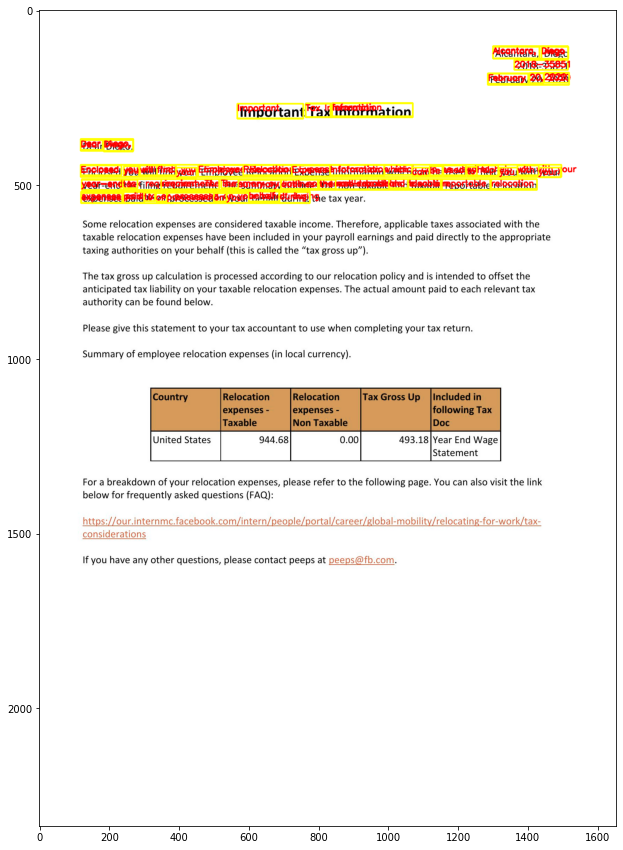

,DetectedText,Type,Confidence
0,"Alcantara, Diego",LINE,99.612518
1,2018-35851,LINE,90.886986
2,"February 20, 2020",LINE,95.436066
3,Important,LINE,99.605919
4,Tax Information,LINE,99.703163
5,"Dear Diego,",LINE,99.199852
6,Enclosed you will find your Employee Relocatio...,LINE,97.154419
7,year-end tax requirement. The summary outlines...,LINE,96.136902
8,the and reportable relocation,LINE,97.148575
9,expenses paid to or processed on your behalf d...,LINE,96.003487


In [18]:
client_rekognition = boto3.client('rekognition', 'us-east-2')
detect_text = pd.DataFrame(
    client_rekognition.detect_text(
        Image={'Bytes': convert_img_to_bytes(file_path)}
    )['TextDetections']
)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
        row.DetectedText
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

detect_text[['DetectedText', 'Type', 'Confidence']]

### AWS Textract

In [20]:
client_textract = boto3.client('textract')

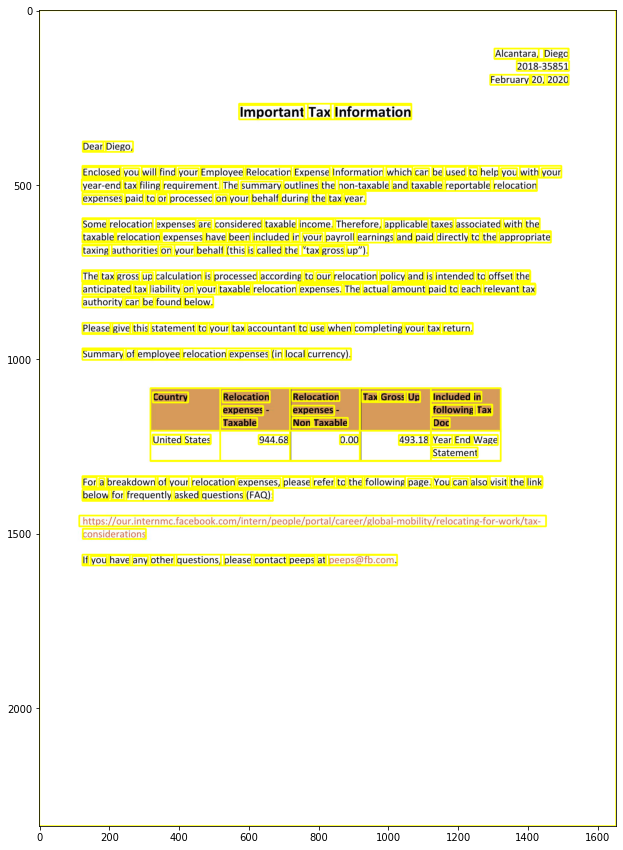

,Text,BlockType,Confidence,Relationships,RowIndex,ColumnIndex,RowSpan,ColumnSpan
0,NaN,PAGE,NaN,"[{'Type': 'CHILD', 'Ids': ['38f45e45-b0dc-435d...",NaN,NaN,NaN,NaN
1,"Alcantara, Diego",LINE,99.751144,"[{'Type': 'CHILD', 'Ids': ['5dc0bbf0-3f3c-43d7...",NaN,NaN,NaN,NaN
2,2018-35851,LINE,98.935303,"[{'Type': 'CHILD', 'Ids': ['96414c96-5a7a-49e1...",NaN,NaN,NaN,NaN
3,"February 20, 2020",LINE,98.016838,"[{'Type': 'CHILD', 'Ids': ['ea03cf2f-e02d-4a9b...",NaN,NaN,NaN,NaN
4,Important Tax Information,LINE,99.595955,"[{'Type': 'CHILD', 'Ids': ['1a6350e9-0a55-44d5...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
264,NaN,CELL,99.978668,"[{'Type': 'CHILD', 'Ids': ['6bc8d5c3-b9fb-46df...",2.0,1.0,1.0,1.0
265,NaN,CELL,99.978668,"[{'Type': 'CHILD', 'Ids': ['89269738-e289-40a8...",2.0,2.0,1.0,1.0
266,NaN,CELL,99.978668,"[{'Type': 'CHILD', 'Ids': ['cb98b70e-a588-4ab5...",2.0,3.0,1.0,1.0
267,NaN,CELL,99.978668,"[{'Type': 'CHILD', 'Ids': ['d041db58-dba2-4459...",2.0,4.0,1.0,1.0


In [39]:
analyze_document = pd.DataFrame(
    client_textract.analyze_document(
        Document={'Bytes': convert_img_to_bytes(file_path)},
        FeatureTypes=['TABLES'],
    )['Blocks']
)

img_bounding_boxes = cv2.imread(file_path)
for row in analyze_document.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

analyze_document[['Text', 'BlockType', 'Confidence', 'Relationships', 'RowIndex', 'ColumnIndex', 'RowSpan',	'ColumnSpan']]